In [1]:
import pathlib
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import xarray as xr
import goes2go
import fsspec

from scipy.interpolate import make_splrep
from scipy.signal import argrelmin
from tobac_flow import abi

import matplotlib.pyplot as plt


/Users/jonesw/miniforge3/envs/hurricane_data_prep/lib/python3.13/site-packages/goes2go/data.py:673: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),
/Users/jonesw/miniforge3/envs/hurricane_data_prep/lib/python3.13/site-packages/goes2go/NEW.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),


In [2]:
ibtracks_file = "IBTrACS.ALL.v04r01.nc"
tracks = xr.open_dataset(ibtracks_file)
track_ida = tracks.where((tracks.name == b"IDA") & (tracks.season == 2021), drop=True)
track_ida = track_ida.where(np.isfinite(track_ida.lat), drop=True)
track_ida = track_ida.squeeze()

In [3]:
lat_spl = make_splrep(track_ida.time.squeeze(), track_ida.lat.squeeze(), s=0.2)
lon_spl = make_splrep(track_ida.time.squeeze(), track_ida.lon.squeeze(), s=0.2)

In [4]:
ida_meso_region = "M1"
ida_meso_start = datetime(2021, 8, 25, 4, 30)
ida_meso_end = datetime(2021, 8, 31, 0)

In [9]:
start_date = max(pd.to_datetime(track_ida.time.values[0]).to_pydatetime(), ida_meso_start)
end_date = min(pd.to_datetime(track_ida.time.values[-1]).to_pydatetime(), ida_meso_end)

meso_files = goes2go.goes_timerange(
    start=start_date, 
    end=end_date,
    download=False,
    domain=ida_meso_region,
    product="ABI-L2-CMIP",
    bands=[1,2,3,13],
)
meso_files_c1 = meso_files[meso_files.product_mode == "ABI-L2-CMIPM1-M6C01"].reset_index(drop=True)
meso_files_c2 = meso_files[meso_files.product_mode == "ABI-L2-CMIPM1-M6C02"].reset_index(drop=True)
meso_files_c3 = meso_files[meso_files.product_mode == "ABI-L2-CMIPM1-M6C03"].reset_index(drop=True)
meso_files_c13 = meso_files[meso_files.product_mode == "ABI-L2-CMIPM1-M6C13"].reset_index(drop=True)

/var/folders/cw/ddjy53ds5h51szdq1630n50r0000gp/T/ipykernel_17476/3596328632.py:1: UserWarning: Discarding nonzero nanoseconds in conversion.
  start_date = max(pd.to_datetime(track_ida.time.values[0]).to_pydatetime(), ida_meso_start)
/var/folders/cw/ddjy53ds5h51szdq1630n50r0000gp/T/ipykernel_17476/3596328632.py:2: UserWarning: Discarding nonzero nanoseconds in conversion.
  end_date = min(pd.to_datetime(track_ida.time.values[-1]).to_pydatetime(), ida_meso_end)


In [14]:
import fsspec
fs = fsspec.filesystem('s3', anon=True)
fsspec_caching = {
    "cache_type": "blockcache",  # block cache stores blocks of fixed size and uses eviction using a LRU strategy.
    "block_size": 8
    * 1024
    * 1024,  # size in bytes per block, adjust depends on the file size but the recommended size is in the MB
}

In [17]:
i = 3000
c1_ds = xr.open_dataset(fs.open(meso_files_c1.file[i], **fsspec_caching), engine="h5netcdf")
c2_ds = xr.open_dataset(fs.open(meso_files_c2.file[i], **fsspec_caching), engine="h5netcdf")
c3_ds = xr.open_dataset(fs.open(meso_files_c3.file[i], **fsspec_caching), engine="h5netcdf")
c13_ds = xr.open_dataset(fs.open(meso_files_c13.file[i], **fsspec_caching), engine="h5netcdf")

In [18]:
c2_ds

<xarray.Dataset> Size: 32MB
Dimensions:                                           (y: 2000, x: 2000,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1)
Coordinates:
    t                                                 datetime64[ns] 8B ...
  * y                                                 (y) float32 8kB 0.08735...
  * x                                                 (x) float32 8kB -0.0442...
    y_image                                           float32 4B ...
    x_image                                           float32 4B ...
    band_wavelength                                   (band) float32 4B ...
    band_id                                           (band) int8 1B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/35)
    CMI                                               (y, x) float32 16MB ...
    DQF                                               (y, x) float32 16MB ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                            int32 4B ...
    y_image_bounds                                    (number_of_image_bounds) float32 8B ...
    x_image_bounds                                    (number_of_image_bounds) float32 8B ...
    ...                                                ...
    focal_plane_temperature_threshold_exceeded_count  float64 8B ...
    maximum_focal_plane_temperature                   float32 4B ...
    focal_plane_temperature_threshold_increasing      float32 4B ...
    focal_plane_temperature_threshold_decreasing      float32 4B ...
    channel_integration_time                          float64 8B ...
    channel_gain_field                                float64 8B ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2021-08-28T14:00:27.8Z
    time_coverage_end:         2021-08-28T14:00:33.5Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        b1cac402-73b7-45ff-8f26-aec83634d5f4

In [24]:
file_time = c2_ds.t.values

In [25]:
file_time

np.datetime64('2021-08-28T14:00:30.725101952')

In [32]:
x, y = abi.get_abi_x_y(lat_spl(file_time).item(), lon_spl(file_time).item(), c2_ds)

In [33]:
x, y

(np.float64(-0.030169038509101742), np.float64(0.07281887222050243))

In [41]:
patch_size = 256
meso_patch = c2_ds.sel(
    x=slice(x-(5.5998564e-05*patch_size/2), x+(5.5998564e-05*patch_size/2)), 
    y=slice(y+(5.5998564e-05*patch_size/2), y-(5.5998564e-05*patch_size/2))
).rename_vars(CMI="CMI_C02")

meso_patch["CMI_C01"] = c1_ds.CMI.interp_like(meso_patch)
meso_patch["CMI_C03"] = c3_ds.CMI.interp_like(meso_patch)
meso_patch["CMI_C13"] = c13_ds.CMI.interp_like(meso_patch)

In [42]:
meso_patch

<xarray.Dataset> Size: 21MB
Dimensions:                                           (y: 1024, x: 1024,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1)
Coordinates:
    t                                                 datetime64[ns] 8B 2021-...
  * y                                                 (y) float32 4kB 0.07998...
  * x                                                 (x) float32 4kB -0.0373...
    y_image                                           float32 4B ...
    x_image                                           float32 4B ...
    band_wavelength                                   (band) float32 4B ...
    band_id                                           (band) int8 1B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/38)
    CMI_C02                                           (y, x) float32 4MB ...
    DQF                                               (y, x) float32 4MB ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                            int32 4B ...
    y_image_bounds                                    (number_of_image_bounds) float32 8B ...
    x_image_bounds                                    (number_of_image_bounds) float32 8B ...
    ...                                                ...
    focal_plane_temperature_threshold_decreasing      float32 4B ...
    channel_integration_time                          float64 8B ...
    channel_gain_field                                float64 8B ...
    CMI_C01                                           (y, x) float32 4MB 0.18...
    CMI_C03                                           (y, x) float32 4MB 0.13...
    CMI_C13                                           (y, x) float32 4MB 257....
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2021-08-28T14:00:27.8Z
    time_coverage_end:         2021-08-28T14:00:33.5Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        b1cac402-73b7-45ff-8f26-aec83634d5f4

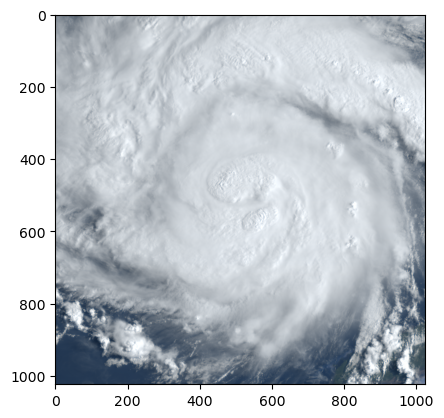

In [43]:
plt.imshow(abi.get_abi_rgb(meso_patch, night_IR=True))

In [44]:
def add_abi_lat_lon_labels(goes_ds, ax=None):
    if ax is None:
        ax = plt.gca()
    
    lats, lons = abi.get_abi_lat_lon(goes_ds)

    round_lats = np.round(lats[:,0])
    wh_round_lats = argrelmin(np.abs(lats[:,0] - round_lats))[0]
    round_lat_values = round_lats[wh_round_lats]
    ax.set_yticks(wh_round_lats, [f'{val:.0f} °N' if val >= 0 else f'{-val:.0f} °S' for val in round_lat_values])

    round_lons = np.round(lons[-1])
    wh_round_lons = argrelmin(np.abs(lons[-1] - round_lons))[0]
    round_lat_values = round_lons[wh_round_lons]
    ax.set_xticks(wh_round_lons, [f'{val:.0f} °E' if val >= 0 else f'{-val:.0f} °W' for val in round_lat_values])

/var/folders/cw/ddjy53ds5h51szdq1630n50r0000gp/T/ipykernel_17476/3206855040.py:5: UserWarning: Discarding nonzero nanoseconds in conversion.
  ax.set_title(f'{pd.to_datetime(file_time).to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")}', loc="right")


Text(1.0, 1.0, '2021-08-28 14:00:30')

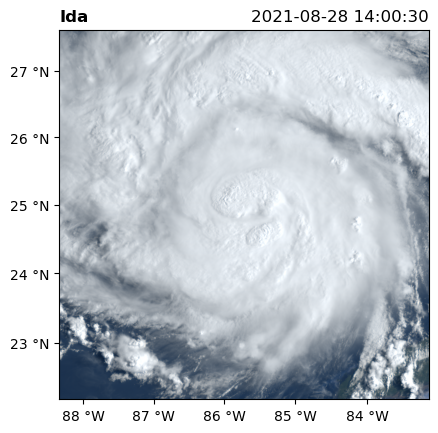

In [47]:
fig, ax = plt.subplots()
ax.imshow(abi.get_abi_rgb( meso_patch, night_IR=True, contrast=125))
add_abi_lat_lon_labels(meso_patch, ax)
ax.set_title("Ida", loc="left", fontweight="bold")
ax.set_title(f'{pd.to_datetime(file_time).to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")}', loc="right")

In [49]:
def get_hires_goes_patch_on_track(
    c1_filename, c2_filename, c3_filename, c13_filename, track_lat_spl, track_lon_spl, patch_size=256
):
    with (
        xr.open_dataset(fs.open(c1_filename, **fsspec_caching), engine="h5netcdf") as c1_ds, 
        xr.open_dataset(fs.open(c2_filename, **fsspec_caching), engine="h5netcdf") as c2_ds, 
        xr.open_dataset(fs.open(c3_filename, **fsspec_caching), engine="h5netcdf") as c3_ds, 
        xr.open_dataset(fs.open(c13_filename, **fsspec_caching), engine="h5netcdf") as c13_ds, 
    ):
        file_time = c2_ds.t.values
        x, y = abi.get_abi_x_y(track_lat_spl([file_time]).item(), track_lon_spl([file_time]).item(), c2_ds)
        meso_patch = c2_ds.sel(
            x=slice(x-(5.5998564e-05*patch_size/2), x+(5.5998564e-05*patch_size/2)), 
            y=slice(y+(5.5998564e-05*patch_size/2), y-(5.5998564e-05*patch_size/2))
        ).rename_vars(CMI="CMI_C02")
        meso_patch["CMI_C01"] = c1_ds.CMI.interp_like(meso_patch)
        meso_patch["CMI_C03"] = c3_ds.CMI.interp_like(meso_patch)
        meso_patch["CMI_C13"] = c13_ds.CMI.interp_like(meso_patch)
        return meso_patch

In [50]:
get_hires_goes_patch_on_track(
    meso_files_c1.file[i], 
    meso_files_c2.file[i], 
    meso_files_c3.file[i], 
    meso_files_c13.file[i], 
    lat_spl, 
    lon_spl, 
)

<xarray.Dataset> Size: 21MB
Dimensions:                                           (y: 1024, x: 1024,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1)
Coordinates:
    t                                                 datetime64[ns] 8B 2021-...
  * y                                                 (y) float32 4kB 0.07998...
  * x                                                 (x) float32 4kB -0.0373...
    y_image                                           float32 4B ...
    x_image                                           float32 4B ...
    band_wavelength                                   (band) float32 4B ...
    band_id                                           (band) int8 1B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/38)
    CMI_C02                                           (y, x) float32 4MB ...
    DQF                                               (y, x) float32 4MB ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                            int32 4B ...
    y_image_bounds                                    (number_of_image_bounds) float32 8B ...
    x_image_bounds                                    (number_of_image_bounds) float32 8B ...
    ...                                                ...
    focal_plane_temperature_threshold_decreasing      float32 4B ...
    channel_integration_time                          float64 8B ...
    channel_gain_field                                float64 8B ...
    CMI_C01                                           (y, x) float32 4MB 0.18...
    CMI_C03                                           (y, x) float32 4MB 0.13...
    CMI_C13                                           (y, x) float32 4MB 257....
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2021-08-28T14:00:27.8Z
    time_coverage_end:         2021-08-28T14:00:33.5Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        b1cac402-73b7-45ff-8f26-aec83634d5f4

/var/folders/cw/ddjy53ds5h51szdq1630n50r0000gp/T/ipykernel_17476/3752162776.py:16: UserWarning: Discarding nonzero nanoseconds in conversion.
  ax.set_title(f'{pd.to_datetime(file_time).to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")}', loc="right")


Text(1.0, 1.0, '2021-08-28 14:00:30')

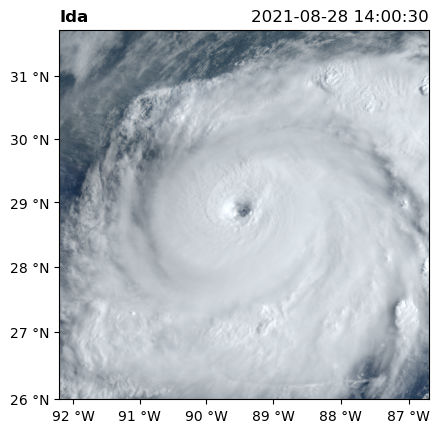

In [52]:
fig, ax = plt.subplots()

i = 4440

meso_patch = get_hires_goes_patch_on_track(
    meso_files_c1.file[i], 
    meso_files_c2.file[i], 
    meso_files_c3.file[i], 
    meso_files_c13.file[i], 
    lat_spl, 
    lon_spl, 
)
ax.imshow(abi.get_abi_rgb( meso_patch, night_IR=True, contrast=125))
add_abi_lat_lon_labels(meso_patch, ax)
ax.set_title("Ida", loc="left", fontweight="bold")
ax.set_title(f'{pd.to_datetime(file_time).to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")}', loc="right")

In [54]:
meso_file_time = meso_files_c1.start + (meso_files_c1.end - meso_files_c1.start)/2

In [55]:
save_dir = pathlib.Path.cwd() / "hurricane_ida_meso_hires_frames"
save_dir.mkdir(exist_ok=True)

In [ ]:
for i in range(len(meso_files_c1)):
    date = meso_file_time[i]
    print(i, date)
    meso_patch = get_hires_goes_patch_on_track(
        meso_files_c1.file[i], 
        meso_files_c2.file[i], 
        meso_files_c3.file[i], 
        meso_files_c13.file[i], 
        lat_spl, 
        lon_spl, 
    )
    fig, ax = plt.subplots()
    ax.imshow(abi.get_abi_rgb(meso_patch, night_IR=True))
    add_abi_lat_lon_labels(meso_patch, ax)
    ax.set_title("Ida", loc="left", fontweight="bold")
    ax.set_title(f'{date.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")}', loc="right")
    fig.savefig(save_dir/f'{date.to_pydatetime().strftime("%Y%m%d%H%M%S")}.png')
    plt.close(fig)

0 2021-08-26 12:00:30.650000
1 2021-08-26 12:01:27.750000
2 2021-08-26 12:02:27.750000
3 2021-08-26 12:03:27.750000
4 2021-08-26 12:04:27.750000
5 2021-08-26 12:05:27.750000
6 2021-08-26 12:06:27.750000
7 2021-08-26 12:07:27.750000
8 2021-08-26 12:08:27.750000
9 2021-08-26 12:09:27.750000
10 2021-08-26 12:10:30.650000
11 2021-08-26 12:11:27.750000
12 2021-08-26 12:12:27.750000
13 2021-08-26 12:13:27.750000
14 2021-08-26 12:14:27.750000
15 2021-08-26 12:15:27.750000
16 2021-08-26 12:16:27.750000
17 2021-08-26 12:17:27.750000
18 2021-08-26 12:18:27.750000
19 2021-08-26 12:19:27.750000
20 2021-08-26 12:20:30.650000
21 2021-08-26 12:21:27.750000
22 2021-08-26 12:22:27.750000
23 2021-08-26 12:23:27.750000
24 2021-08-26 12:24:27.750000
25 2021-08-26 12:25:27.750000
26 2021-08-26 12:26:27.750000
27 2021-08-26 12:27:27.750000
28 2021-08-26 12:28:27.750000
29 2021-08-26 12:29:27.750000
30 2021-08-26 12:30:30.650000
31 2021-08-26 12:31:27.750000
32 2021-08-26 12:32:27.750000
33 2021-08-26 12:33: